In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, k

## Constants

In [3]:
n_air = 1 # Index of refraction of air.
n_soap = 1.33 # Index of refraction of soap + water mixture.

## Single Wavelength

First look at the behavior of a single wavelength of light for various film thicknesses.

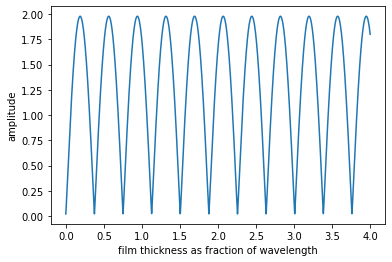

In [15]:
# https://en.wikipedia.org/wiki/Fresnel_equations
def getRs(theta_i, theta_t, n1, n2):
    return ((n1 * math.cos(theta_i) - n2 * math.cos(theta_t)) / (n1 * math.cos(theta_i) + n2 * math.cos(theta_t)))**2
def getRp(theta_i, theta_t, n1, n2):
    return ((n1 * math.cos(theta_t) - n2 * math.cos(theta_i)) / (n1 * math.cos(theta_t) + n2 * math.cos(theta_i)))**2      
def getR(theta_i, theta_t, n1, n2):
    # Assuming unpolarized light, equal contributions of S and P polarizations.
    return (getRs(theta_i, theta_t, n1, n2) + getRp(theta_i, theta_t, n1, n2)) / 2.

# https://en.wikipedia.org/wiki/Snell%27s_law
def calcAngleViaSnell(angle, n1, n2):
    return math.asin(n1 * math.sin(angle) / n2)
            
# wavelength is the wavelength of incident light in nm
# thickness is the thickness of the film in nm
def getAmplitude(wavelength, thickness, incidentAngle = 0):
    # https://en.wikipedia.org/wiki/Thin-film_interference

    # Calc angle of rear reflection via snell's law.
    theta = calcAngleViaSnell(incidentAngle, n_air, n_soap)

    # # The wavelength inside a medium is scaled by the index of refraction.
    # wavelength_soap = wavelength / n_soap
    # wavelength_air = wavelength / n_air
    # # First calc phase shift of reflection at rear surface, based on film thickness.
    # phaseDelta = 2 * thickness / math.cos(theta) * 2 * math.pi / wavelength_soap  
    # # There is an additional path to compute, the segment AJ from:
    # # https://www.glassner.com/wp-content/uploads/2014/04/CG-CGA-PDF-00-11-Soap-Bubbles-2-Nov00.pdf
    # phaseDelta -= 2 * thickness * math.tan(theta) * math.sin(incidentAngle) * 2 * math.pi / wavelength_air
    # Simplified to:
    phaseDelta = 2 * thickness * n_soap * math.cos(theta) * 2 * math.pi / wavelength
    
    # Add a reflection phase change where needed.
    # https://en.wikipedia.org/wiki/Reflection_phase_change
    if n_air < n_soap:
        phaseDelta -= math.pi
    if n_air > n_soap:
        phaseDelta += math.pi
    
    # Amplitudes of front and rear reflections.
    front_refl_amp = getR(incidentAngle, theta, n_air, n_soap)
    front_trans_amp = 1. - front_refl_amp
    rear_refl_amp = front_trans_amp * getR(theta, incidentAngle, n_soap, n_air)
    # Normalize amps so that front_refl_amp = 1
    # This will lose some angle dependent luminance info, but easy to reconstruct later.
    rear_refl_amp /= front_refl_amp
    front_refl_amp = 1
        
    # Calc amplitude of resulting sine wave by adding front and rear reflections.
    # http://scipp.ucsc.edu/~haber/ph5B/addsine.pdf
    return np.sqrt(front_refl_amp * front_refl_amp + rear_refl_amp * rear_refl_amp
        + 2 * front_refl_amp * rear_refl_amp * np.cos(phaseDelta))

wavelength = 700.0 # The wavelength doesn't really matter, it's all about the ratio thickness / wavelength.
thicknesses = np.arange(0., wavelength * 4, 1)
amplitudes = getAmplitude(wavelength, thicknesses)

plt.plot(thicknesses/wavelength, amplitudes) 
plt.xlabel('film thickness as fraction of wavelength');
plt.ylabel('amplitude');

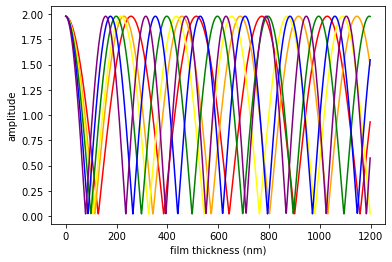

In [13]:
# colors as wavelengths (these are approximate)
red = 685
orange = 610
yellow = 580
green = 530
blue = 470
purple = 420

wavelengths = np.reshape(np.array([red, orange, yellow, green, blue, purple]), (1, -1))
thicknesses = np.reshape(np.arange(1., 1200., 1), (-1, 1))

amplitudes = getAmplitude(wavelengths, thicknesses)
plt.plot(amplitudes[:, 0], color='red');
plt.plot(amplitudes[:, 1], color='orange');
plt.plot(amplitudes[:, 2], color='yellow');
plt.plot(amplitudes[:, 3], color='green');
plt.plot(amplitudes[:, 4], color='blue');
plt.plot(amplitudes[:, 5], color='purple');
plt.xlabel('film thickness (nm)');
plt.ylabel('amplitude');

## Spectrum

Now look at the behavior of the entire visible spectrum (380-780nm).  First we need a way to convert an output spectrum to a single RGB value.

In [6]:
# ColourSystem class for converting spectrum to rgb color.
# copied from https://scipython.com/blog/converting-a-spectrum-to-a-colour/

def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

# Lookup for converting wavelength to xyz.
# from https://scipython.com/blog/converting-a-spectrum-to-a-colour/
wavelength_lookup = np.array([
[380, 0.0014, 0.0000, 0.0065],
[385, 0.0022, 0.0001, 0.0105],
[390, 0.0042, 0.0001, 0.0201],
[395, 0.0076, 0.0002, 0.0362],
[400, 0.0143, 0.0004, 0.0679],
[405, 0.0232, 0.0006, 0.1102],
[410, 0.0435, 0.0012, 0.2074],
[415, 0.0776, 0.0022, 0.3713],
[420, 0.1344, 0.0040, 0.6456],
[425, 0.2148, 0.0073, 1.0391],
[430, 0.2839, 0.0116, 1.3856],
[435, 0.3285, 0.0168, 1.6230],
[440, 0.3483, 0.0230, 1.7471],
[445, 0.3481, 0.0298, 1.7826],
[450, 0.3362, 0.0380, 1.7721],
[455, 0.3187, 0.0480, 1.7441],
[460, 0.2908, 0.0600, 1.6692],
[465, 0.2511, 0.0739, 1.5281],
[470, 0.1954, 0.0910, 1.2876],
[475, 0.1421, 0.1126, 1.0419],
[480, 0.0956, 0.1390, 0.8130],
[485, 0.0580, 0.1693, 0.6162],
[490, 0.0320, 0.2080, 0.4652],
[495, 0.0147, 0.2586, 0.3533],
[500, 0.0049, 0.3230, 0.2720],
[505, 0.0024, 0.4073, 0.2123],
[510, 0.0093, 0.5030, 0.1582],
[515, 0.0291, 0.6082, 0.1117],
[520, 0.0633, 0.7100, 0.0782],
[525, 0.1096, 0.7932, 0.0573],
[530, 0.1655, 0.8620, 0.0422],
[535, 0.2257, 0.9149, 0.0298],
[540, 0.2904, 0.9540, 0.0203],
[545, 0.3597, 0.9803, 0.0134],
[550, 0.4334, 0.9950, 0.0087],
[555, 0.5121, 1.0000, 0.0057],
[560, 0.5945, 0.9950, 0.0039],
[565, 0.6784, 0.9786, 0.0027],
[570, 0.7621, 0.9520, 0.0021],
[575, 0.8425, 0.9154, 0.0018],
[580, 0.9163, 0.8700, 0.0017],
[585, 0.9786, 0.8163, 0.0014],
[590, 1.0263, 0.7570, 0.0011],
[595, 1.0567, 0.6949, 0.0010],
[600, 1.0622, 0.6310, 0.0008],
[605, 1.0456, 0.5668, 0.0006],
[610, 1.0026, 0.5030, 0.0003],
[615, 0.9384, 0.4412, 0.0002],
[620, 0.8544, 0.3810, 0.0002],
[625, 0.7514, 0.3210, 0.0001],
[630, 0.6424, 0.2650, 0.0000],
[635, 0.5419, 0.2170, 0.0000],
[640, 0.4479, 0.1750, 0.0000],
[645, 0.3608, 0.1382, 0.0000],
[650, 0.2835, 0.1070, 0.0000],
[655, 0.2187, 0.0816, 0.0000],
[660, 0.1649, 0.0610, 0.0000],
[665, 0.1212, 0.0446, 0.0000],
[670, 0.0874, 0.0320, 0.0000],
[675, 0.0636, 0.0232, 0.0000],
[680, 0.0468, 0.0170, 0.0000],
[685, 0.0329, 0.0119, 0.0000],
[690, 0.0227, 0.0082, 0.0000],
[695, 0.0158, 0.0057, 0.0000],
[700, 0.0114, 0.0041, 0.0000],
[705, 0.0081, 0.0029, 0.0000],
[710, 0.0058, 0.0021, 0.0000],
[715, 0.0041, 0.0015, 0.0000],
[720, 0.0029, 0.0010, 0.0000],
[725, 0.0020, 0.0007, 0.0000],
[730, 0.0014, 0.0005, 0.0000],
[735, 0.0010, 0.0004, 0.0000],
[740, 0.0007, 0.0002, 0.0000],
[745, 0.0005, 0.0002, 0.0000],
[750, 0.0003, 0.0001, 0.0000],
[755, 0.0002, 0.0001, 0.0000],
[760, 0.0002, 0.0001, 0.0000],
[765, 0.0001, 0.0000, 0.0000],
[770, 0.0001, 0.0000, 0.0000],
[775, 0.0001, 0.0000, 0.0000],
[780, 0.0000, 0.0000, 0.0000]])

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.delete(wavelength_lookup, 0, 1)

    def __init__(self, red, green, blue, white):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T 
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
#         print(rgb)
#         if np.any(rgb < 0):
#             # We're not in the RGB gamut: approximate by desaturating
#             w = - np.min(rgb)
#             rgb += w

        # TODO: Figure out a better way to translate color back to rgb gamut.
        rgb = np.clip(rgb, 0., 1.)

        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        return XYZ / 130.0 # Using a scaling factor to keep in range of rgb, but preserve amplitude.

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)
cs_hdtv = ColourSystem(red=xyz_from_xy(0.67, 0.33),
                       green=xyz_from_xy(0.21, 0.71),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs_smpte = ColourSystem(red=xyz_from_xy(0.63, 0.34),
                        green=xyz_from_xy(0.31, 0.595),
                        blue=xyz_from_xy(0.155, 0.070),
                        white=illuminant_D65)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

Compute the spectra for a number of thicknesses and compute RGB values for the resulting spectra.

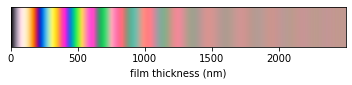

In [16]:
wavelengths = np.reshape(np.arange(380., 781., 5), (1, -1))
thicknesses = np.reshape(np.arange(1., 2500., 1), (-1, 1))

spectra = getAmplitude(wavelengths, thicknesses)
strip = [[cs_srgb.spec_to_rgb(spectra[i]) for i in range(0, len(thicknesses))]]

imgplot = plt.imshow(strip, aspect=300)
plt.yticks([]);
plt.xlabel('film thickness (nm)');

## Correction for input spectrum of sun

The light from the sun is not uniform in amplitude across the visible spectrum, it shifts a bit more blue.  Apply this correction to the calculations.

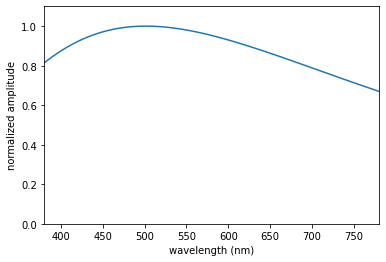

In [8]:
# https://scipython.com/blog/converting-a-spectrum-to-a-colour/
def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

wavelengths_array = np.ravel(wavelengths)
# Genrate a spectrum for the sun (T = 5777K).
sun_spectrum = planck(wavelengths_array, 5777)
# Normalize so max amp is equal to 1.
sun_spectrum /= np.max(sun_spectrum)

plt.plot(wavelengths_array, sun_spectrum)
plt.ylabel('normalized amplitude');
plt.xlabel('wavelength (nm)');
plt.xlim([np.min(wavelengths_array), np.max(wavelengths_array)]);
plt.ylim([0, 1.1]);

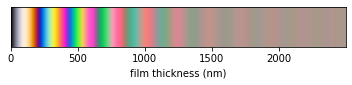

In [17]:
spectra = getAmplitude(wavelengths, thicknesses)
strip = [[cs_srgb.spec_to_rgb(spectra[i] * sun_spectrum) for i in range(0, len(thicknesses))]]

imgplot = plt.imshow(strip, aspect=300)
plt.yticks([]);
plt.xlabel('film thickness (nm)');

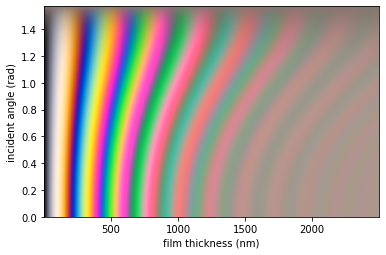

In [18]:
# Calc for many incident angles and thicknesses.
angles = np.arange(0., math.pi/2, 0.001)
pixels = [[cs_srgb.spec_to_rgb(spectrum * sun_spectrum) for spectrum in getAmplitude(wavelengths, thicknesses, angle)] for angle in angles]

xmin = np.min(thicknesses)
xmax = np.max(thicknesses)
ymin = np.min(angles)
ymax = np.max(angles)
imgplot = plt.imshow(pixels, interpolation='none', aspect = len(angles) / (ymax - ymin), extent=[xmin, xmax, ymax, ymin])
plt.gca().invert_yaxis();
plt.ylabel('incident angle (rad)');
plt.xlabel('film thickness (nm)');

## Save Image

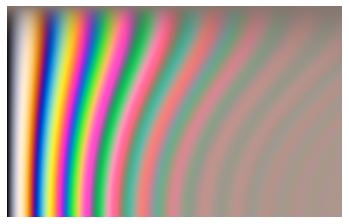

In [20]:
imgplot = plt.imshow(pixels, interpolation='none')
plt.gca().invert_yaxis()
plt.axis('off')
plt.savefig('lookup.png', dpi=600, bbox_inches='tight', pad_inches=0)